# Installs

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
#from datetime import datetime
import datetime
#from pyathena import connect
import random

In [3]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [4]:
import numpy as np
import pandas as pd

import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor    
# from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
print("OK")

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from xgboost import plot_importance

import boto3

OK


## Load Data

In [5]:
# Read from S3 - Enter filename for Key
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-w210-eth', Key='pipeline_df_20211113_2.csv')
data = pd.read_csv(obj['Body'])
data.head()

,number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12961718,2021-08-04 23:59:04,NaN,2021-08-05 00:00:04,7774193366499997,2.846921e+22,73653,14970676,14957821,1628121604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12961719,2021-08-04 23:59:07,NaN,2021-08-05 00:00:07,7778126798308205,2.846922e+22,103790,14985294,14975998,1628121607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12961720,2021-08-04 23:59:47,NaN,2021-08-05 00:00:47,7766870496834469,2.846923e+22,101080,14999927,14981552,1628121647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12961721,2021-08-05 00:00:03,NaN,2021-08-05 00:01:03,7770800353022723,2.846923e+22,68027,15000000,14987640,1628121663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12961722,2021-08-05 00:00:25,12961719.0,2021-08-05 00:01:25,7767143455866321,2.846924e+22,543,15000000,0,1628121685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.rename(columns={'number': 'block_number'}, inplace=True)

In [7]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12961718,2021-08-04 23:59:04,NaN,2021-08-05 00:00:04,7774193366499997,2.846921e+22,73653,14970676,14957821,1628121604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12961719,2021-08-04 23:59:07,NaN,2021-08-05 00:00:07,7778126798308205,2.846922e+22,103790,14985294,14975998,1628121607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12961720,2021-08-04 23:59:47,NaN,2021-08-05 00:00:47,7766870496834469,2.846923e+22,101080,14999927,14981552,1628121647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12961721,2021-08-05 00:00:03,NaN,2021-08-05 00:01:03,7770800353022723,2.846923e+22,68027,15000000,14987640,1628121663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12961722,2021-08-05 00:00:25,12961719.0,2021-08-05 00:01:25,7767143455866321,2.846924e+22,543,15000000,0,1628121685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'b

In [9]:
print("min block number:", data.block_number.min())
print("median block number:", data.block_number.median())
print("max block number:", data.block_number.max())

min block number: 12961718
median block number: 13244788.0
max block number: 13527858


In [10]:
# print("length of data before dropping NAs:", len(data))
# data = data.dropna()
# print("length of data after dropping NAs:", len(data))

In [11]:
pd.options.display.max_columns = None
data.describe()

,block_number,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
count,5.661410e+05,5.661370e+05,5.661410e+05,5.661410e+05,5.661410e+05,5.661410e+05,5.661410e+05,5.661410e+05,566141.000000,5.628590e+05,5.661400e+05,5.661400e+05,566140.000000,566140.000000,562858.000000,566136.000000,566116.000000,566091.000000,566041.000000,5.661360e+05,5.661160e+05,5.660910e+05,566041.000000,566136.000000,566116.000000,566091.000000,566041.000000,566136.000000,566116.000000,566091.000000,566041.000000,562854.000000,562834.000000,562809.000000,562759.000000,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,556936.000000,556931.000000,556911.000000,556886.000000,556836.000000,5.569310e+05,5.569110e+05,5.568860e+05,5.568360e+05,556931.000000,556911.000000,556886.000000,556836.000000,5.569310e+05,5.569110e+05,5.568860e+05,5.568360e+05,556931.000000,556911.000000,556886.000000,556836.000000
mean,1.324479e+07,1.324478e+07,8.881305e+15,3.086043e+22,7.718583e+04,2.992329e+07,1.544216e+07,1.631910e+09,188.815684,8.389799e+10,7.155172e-07,2.872804e-07,5.531328,0.000002,0.003672,0.000004,0.000014,0.000032,0.000068,1.436403e-06,5.745620e-06,1.292769e-05,0.000027,4.114598,4.054488,4.088010,4.129498,0.000010,0.000036,0.000080,0.000167,0.012018,0.031181,0.061357,0.086395,2.166753e+04,1.889297e+05,8.506328e+10,1.022344e+11,2.134077e+04,8.907296e+04,8.506328e+10,1.022344e+11,313.955009,0.125859,0.133857,0.138133,0.142811,inf,inf,inf,inf,0.104803,0.117146,0.123761,0.127360,inf,inf,inf,inf,1.718159,1.703634,1.717208,1.731129
std,1.634310e+05,1.634298e+05,7.772472e+14,1.456622e+21,5.759466e+04,1.146282e+06,1.029474e+07,2.193156e+06,142.875043,7.564743e+10,7.033183e-04,1.283190e-08,30.235284,0.001540,0.086000,0.001557,0.003085,0.004593,0.006636,6.415319e-08,2.565340e-07,5.769133e-07,0.000001,23.649602,23.228035,23.283212,23.399238,0.003215,0.006055,0.008896,0.012699,0.160737,0.333681,0.758804,0.915449,7.859786e+04,1.995758e+05,9.382589e+10,2.328123e+11,7.454271e+04,9.926500e+04,9.382589e+10,2.328123e+11,254.926877,1.206740,1.265515,1.248601,1.262789,NaN,NaN,NaN,NaN,1.144399,1.219309,1.305462,1.260407,NaN,NaN,NaN,NaN,8.335019,8.288193,8.585240,8.485832
min,1.296172e+07,1.296172e+07,7.213602e+15,2.846921e+22,5.200000e+02,1.489037e+07,

In [12]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12961718,2021-08-04 23:59:04,NaN,2021-08-05 00:00:04,7774193366499997,2.846921e+22,73653,14970676,14957821,1628121604,152,NaN,2021-08-05 00:00:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12961719,2021-08-04 23:59:07,NaN,2021-08-05 00:00:07,7778126798308205,2.846922e+22,103790,14985294,14975998,1628121607,235,NaN,2021-08-05 00:00:07,0.000506,2.732119e-07,0.409175,0.000976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,173559.787234,0.0,6.130997e+10,19730.0,63727.651064,0.0,6.130997e+10,470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12961720,2021-08-04 23:59:47,NaN,2021-08-05 00:00:47,7766870496834469,2.846923e+22,101080,14999927,14981552,1628121647,196,NaN,2021-08-05 00:00:47,-0.001447,2.728164e-07,-0.026110,0.000976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,255567.969388,0.0,5.420722e+10,19853.0,76436.489796,0.0,5.420722e+10,392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12961721,2021-08-05 00:00:03,NaN,2021-08-05 00:01:03,7770800353022723,2.846923e+22,68027,15000000,14987640,1628121663,194,NaN,2021-08-05 00:01:03,0.000506,2.729544e-07,-0.326998,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,223509.886598,0.0,5.656310e+10,19301.0,77255.876289,0.0,5.656310e+10,388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12961722,2021-08-05 00:00:25,12961719.0,2021-08-05 00:01:25,7767143455866321,2.846924e+22,543,15000000,0,1628121685,0,NaN,2021-08-05 00:01:25,-0.000471,2.728259e-07,-0.992018,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create train / dev / test splits

In [13]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'b

### Set X & Y columns

In [14]:

X_columns = ['lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block', 'gas_mean_pct_chg_last_5',
       'gas_mean_pct_chg_last_25_to_5', 'gas_mean_pct_chg_last_50_to_5',
       'gas_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
       'gas_price_mean_pct_chg_last_25_to_5',
       'gas_price_mean_pct_chg_last_50_to_5',
       'gas_price_mean_pct_chg_last_100_to_5', 'gas_used_mean_pct_chg_last_5',
       'gas_used_mean_pct_chg_last_25_to_5',
       'gas_used_mean_pct_chg_last_50_to_5',
       'gas_used_mean_pct_chg_last_100_to_5',
       'effective_gas_price_mean_pct_chg_last_5',
       'effective_gas_price_mean_pct_chg_last_25_to_5',
       'effective_gas_price_mean_pct_chg_last_50_to_5',
       'effective_gas_price_mean_pct_chg_last_100_to_5',
       'number_transactions_in_block_pct_chg_last_5',
       'number_transactions_in_block_pct_chg_last_25_to_5',
       'number_transactions_in_block_pct_chg_last_50_to_5',
       'number_transactions_in_block_pct_chg_last_100_to_5']

Y_column = ['effective_gas_price_mean']


In [15]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'b

### Check validity of data

In [16]:
data[X_columns].describe()

,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
count,5.661370e+05,5.661410e+05,5.661410e+05,5.661410e+05,5.661410e+05,5.661410e+05,5.661410e+05,566141.000000,5.628590e+05,5.661400e+05,5.661400e+05,566140.000000,566140.000000,562858.000000,566136.000000,566116.000000,566091.000000,566041.000000,5.661360e+05,5.661160e+05,5.660910e+05,566041.000000,566136.000000,566116.000000,566091.000000,566041.000000,566136.000000,566116.000000,566091.000000,566041.000000,562854.000000,562834.000000,562809.000000,562759.000000,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,556936.000000,556931.000000,556911.000000,556886.000000,556836.000000,5.569310e+05,5.569110e+05,5.568860e+05,5.568360e+05,556931.000000,556911.000000,556886.000000,556836.000000,5.569310e+05,5.569110e+05,5.568860e+05,5.568360e+05,556931.000000,556911.000000,556886.000000,556836.000000
mean,1.324478e+07,8.881305e+15,3.086043e+22,7.718583e+04,2.992329e+07,1.544216e+07,1.631910e+09,188.815684,8.389799e+10,7.155172e-07,2.872804e-07,5.531328,0.000002,0.003672,0.000004,0.000014,0.000032,0.000068,1.436403e-06,5.745620e-06,1.292769e-05,0.000027,4.114598,4.054488,4.088010,4.129498,0.000010,0.000036,0.000080,0.000167,0.012018,0.031181,0.061357,0.086395,2.166753e+04,1.889297e+05,8.506328e+10,1.022344e+11,2.134077e+04,8.907296e+04,313.955009,0.125859,0.133857,0.138133,0.142811,inf,inf,inf,inf,0.104803,0.117146,0.123761,0.127360,inf,inf,inf,inf,1.718159,1.703634,1.717208,1.731129
std,1.634298e+05,7.772472e+14,1.456622e+21,5.759466e+04,1.146282e+06,1.029474e+07,2.193156e+06,142.875043,7.564743e+10,7.033183e-04,1.283190e-08,30.235284,0.001540,0.086000,0.001557,0.003085,0.004593,0.006636,6.415319e-08,2.565340e-07,5.769133e-07,0.000001,23.649602,23.228035,23.283212,23.399238,0.003215,0.006055,0.008896,0.012699,0.160737,0.333681,0.758804,0.915449,7.859786e+04,1.995758e+05,9.382589e+10,2.328123e+11,7.454271e+04,9.926500e+04,254.926877,1.206740,1.265515,1.248601,1.262789,NaN,NaN,NaN,NaN,1.144399,1.219309,1.305462,1.260407,NaN,NaN,NaN,NaN,8.335019,8.288193,8.585240,8.485832
min,1.296172e+07,7.213602e+15,2.846921e+22,5.200000e+02,1.489037e+07,0.000000e+00,1.628122e+09,0.000000,1.000000e+09,-8.297229e-03,2.519518e-07,-0.999018,-0.000977,-0.125000,-0.012636,-0.017439,-0.022710,-0.030165,1.260136e-06,5.043736e-06,1.135410e-05,0.000024

In [17]:
#data[data.number_transactions_in_block_pct_chg_last_5.isna()]
data.number_transactions_in_block_pct_chg_last_5.isna().sum()

9210

In [18]:
print("Percent NA's")
data[X_columns].isna().sum()/data[X_columns].count()

Percent NA's


lag_cutoff_60                                         0.000000
latest_avail_60                                       0.000007
datetime                                              0.000000
difficulty                                            0.000000
total_difficulty                                      0.000000
                                                        ...   
effective_gas_price_mean_pct_chg_last_100_to_5        0.016710
number_transactions_in_block_pct_chg_last_5           0.016537
number_transactions_in_block_pct_chg_last_25_to_5     0.016574
number_transactions_in_block_pct_chg_last_50_to_5     0.016619
number_transactions_in_block_pct_chg_last_100_to_5    0.016710
Length: 64, dtype: float64

In [19]:
na_df = pd.DataFrame(data[X_columns].isna().sum()/data[X_columns].count(), columns=['na'])
na_df.sort_values(by='na', ascending=False)

,na
number_transactions_in_block_pct_chg_last_100_to_5,0.01671
effective_gas_price_mean_pct_chg_last_100_to_5,0.01671
gas_mean_pct_chg_last_100_to_5,0.01671
gas_used_mean_pct_chg_last_100_to_5,0.01671
gas_price_mean_pct_chg_last_100_to_5,0.01671
...,...
size,0.00000
total_difficulty,0.00000
difficulty,0.00000
datetime,0.00000


In [20]:
data[X_columns].dropna().shape

(553603, 64)

In [21]:
data_original = data.copy()
data = data[X_columns+Y_column+['block_number']].dropna()

In [22]:
data.shape

(553603, 66)

### Create the data sets

In [23]:
data['datetime'] = pd.to_datetime(data['datetime'])
# val_date = pd.to_datetime(datetime.date(2021, 10, 1))
# test_date = pd.to_datetime(datetime.date(2021, 10, 15))
val_date = pd.to_datetime(datetime.date(2021, 10, 5))
test_date = pd.to_datetime(datetime.date(2021, 10, 19))

X_train = data[data['datetime']<val_date][X_columns]
Y_train = data[data['datetime']<val_date][Y_column]

X_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][X_columns]
Y_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][Y_column]

X_test = data[data['datetime']>test_date][X_columns]
Y_test = data[data['datetime']>test_date][Y_column]

# X_train = data[data.block_number<12967800][X_columns]
# Y_train = data[data.block_number<12967800][Y_column]

# X_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][X_columns]
# Y_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][Y_column]

# X_test = data[data.block_number>13141000][X_columns]
# Y_test = data[data.block_number>13141000][Y_column]

#create data sets that concatenates X's and y's for EDA
train_data = X_train.copy()
dev_data = X_dev.copy()
test_data = X_test.copy()

In [24]:
print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_dev shape:", Y_dev.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (384210, 64)
X_dev shape: (87632, 64)
X_test shape: (81761, 64)
Y_train shape: (384210, 1)
Y_dev shape: (87632, 1)
Y_test shape: (81761, 1)


## Linear Regression

#### Create a heatmap to limit multicollinearity when testing regressions

In [ ]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Features', fontdict={'fontsize':12}, pad=12);

#### Manually create feature list

In [25]:
lin_reg_features_list = [
    ['size_pct_chg_last_25_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_25_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_25_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_25_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_25_to_5', 'effective_gas_price_mean_pct_chg_last_5'],
    ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5'],
    ['size_pct_chg_last_100_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5']
]

#### Run Regressions

In [26]:
# Prep the results dataframe

# Collapse the list of features into one field
temp_list = []
for i in range(len(lin_reg_features_list)):
    temp_list.append(','.join(lin_reg_features_list[i]))
linear_regression_results_df = pd.DataFrame(temp_list,
                                            columns=['Features'])

# Create empty columns for the results
linear_regression_results_df['Coefficients'] = ''
linear_regression_results_df['Rsq_Train'] = ''
linear_regression_results_df['Rsq_Dev'] = ''
linear_regression_results_df['RMSE_Train'] = ''
linear_regression_results_df['RMSE_Dev'] = ''
linear_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"size_pct_chg_last_25_to_5,size_pct_chg_last_5,...",,,,,
1,"size_pct_chg_last_50_to_5,size_pct_chg_last_5,...",,,,,
2,"size_pct_chg_last_100_to_5,size_pct_chg_last_5...",,,,,


In [27]:
lr_coeff_list = []
lr_rmse_train_list = []
lr_rmse_dev_list = []
lr_rsq_train_list = []
lr_rsq_dev_list = []

for l in lin_reg_features_list:
    lin_reg = LinearRegression(normalize=True, n_jobs=-1)

    lin_reg_features = l

    # fit train and test data. 
    lin_reg.fit(X_train[l], Y_train)

    # Predict train data. 
    y_train_pred = lin_reg.predict(X_train[l])

    # Get training metrics
    lr_mse_train = mean_squared_error(Y_train, y_train_pred)
    lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

    # Predict dev data. 
    y_dev_pred_lr = lin_reg.predict(X_dev[l])

    lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
    lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
    lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)
    
    # Store all of the results in lists
    lr_coeff_list.append(lin_reg.coef_)
    lr_rmse_train_list.append(lr_rmse_train)
    lr_rmse_dev_list.append(lr_rmse_dev)
    lr_rsq_train_list.append(lr_r2score_train)
    lr_rsq_dev_list.append(lr_r2score_dev)

# Store the lists of results into the results dataframe
linear_regression_results_df['Coefficients'] = lr_coeff_list
linear_regression_results_df['RMSE_Train'] = lr_rmse_train_list
linear_regression_results_df['RMSE_Dev'] = lr_rmse_dev_list
linear_regression_results_df['Rsq_Train'] = lr_rsq_train_list
linear_regression_results_df['Rsq_Dev'] = lr_rsq_dev_list

linear_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"size_pct_chg_last_25_to_5,size_pct_chg_last_5,...","[[-2384474.4405810013, -13111386.876353672, 14...",0.836629,0.230357,1.091309e+11,1.217207e+11
1,"size_pct_chg_last_50_to_5,size_pct_chg_last_5,...","[[-6302270.332835375, -3845897.756692627, 7216...",0.857942,0.261015,1.017637e+11,1.192717e+11
2,"size_pct_chg_last_100_to_5,size_pct_chg_last_5...","[[-2957263.390941601, -9493052.939690346, 6314...",0.864984,0.292465,9.920942e+10,1.167061e+11


#### Run Final Linear Regression Model

In [28]:
# Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)

lin_reg_features = ['size_pct_chg_last_100_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5']


# fit train and test data. 
lin_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred = lin_reg.predict(X_train[lin_reg_features])

# Get training metrics
lr_mse_train = mean_squared_error(Y_train, y_train_pred)
lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Linear Regression model on train data is: %.4f'%lr_mse_train)
print ('The RMSE of the Linear Regression model on train data is: %.4f'%lr_rmse_train)
print ('The R^2 of the Linear Regression model on train data is: %.4f'%lr_r2score_train)

# Predict dev data. 
y_dev_pred_lr = lin_reg.predict(X_dev[lin_reg_features])

lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)

print ('The MSE of the Linear Regression model on dev data is: %.4f'%lr_mse_dev)
print ('The RMSE of the Linear Regression model on dev data is: %.4f'%lr_rmse_dev)
print ('The R^2 of the Linear Regression model on dev data is: %.4f'%lr_r2score_dev)

lin_reg.coef_

The MSE of the Linear Regression model on train data is: 9842508421512034254848.0000
The RMSE of the Linear Regression model on train data is: 99209417000.1620
The R^2 of the Linear Regression model on train data is: 0.8650
The MSE of the Linear Regression model on dev data is: 13620324870303697076224.0000
The RMSE of the Linear Regression model on dev data is: 116706147525.7567
The R^2 of the Linear Regression model on dev data is: 0.2925


array([[-2.95726339e+06, -9.49305294e+06,  6.31479335e+10,
         8.47155206e+10, -7.59036361e+23,  7.84981295e+21,
        -1.07723920e+08,  8.80538675e+07,  7.59036361e+23,
        -7.84981295e+21]])

In [29]:
import statsmodels.api as sm
mod = sm.OLS(Y_train,X_train[lin_reg_features])
mod2 = mod.fit()
print(mod2.summary())

                                    OLS Regression Results                                   
Dep. Variable:     effective_gas_price_mean   R-squared (uncentered):                   0.805
Model:                                  OLS   Adj. R-squared (uncentered):              0.805
Method:                       Least Squares   F-statistic:                          1.984e+05
Date:                      Sun, 14 Nov 2021   Prob (F-statistic):                        0.00
Time:                              14:14:26   Log-Likelihood:                     -1.0366e+07
No. Observations:                    384210   AIC:                                  2.073e+07
Df Residuals:                        384202   BIC:                                  2.073e+07
Df Model:                                 8                                                  
Covariance Type:                  nonrobust                                                  
                                                         coe

In [30]:
linear_regression_results_df.to_csv(r'data/linear_regression_results.csv')

In [67]:
#len(y_dev_pred_lr)
#X_train
Y_dev['effective_gas_price_mean']

393975    6.559103e+11
393976    7.362075e+11
393977    7.663225e+11
393978    7.900478e+11
393979    7.714207e+11
              ...     
483121    9.101150e+10
483122    8.784644e+10
483123    9.296818e+10
483125    8.356565e+10
483126    8.613604e+10
Name: effective_gas_price_mean, Length: 87632, dtype: float64

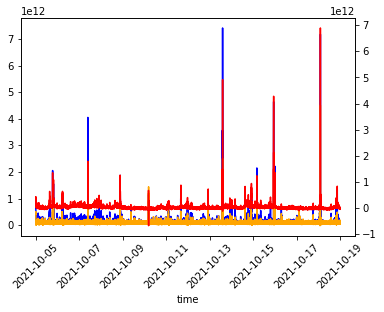

In [69]:
x = X_dev['datetime']
y1 = Y_dev
y2 = y_dev_pred_lr
y3 = Y_dev - y_dev_pred_lr

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
#ax2.plot(x, y2, color='orange')
ax1.plot(x, y2, color='orange')
ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

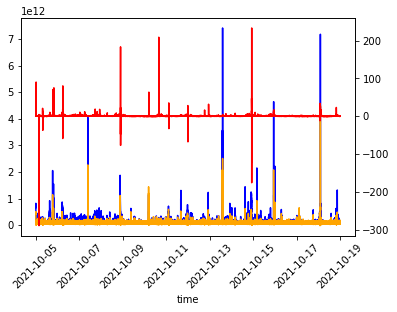

In [116]:
x = X_dev['datetime']
y1 = Y_dev
y2 = y_dev_pred_lr
y3 = (Y_dev - y_dev_pred_lr) / y_dev_pred_lr

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
#ax2.plot(x, y2, color='orange')
ax1.plot(x, y2, color='orange')
ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

In [82]:
y3.sort_values(by='effective_gas_price_mean')

,effective_gas_price_mean
394926,-290.736389
457227,-177.130279
457274,-121.297883
418907,-78.105924
438652,-68.789314
...,...
394086,89.555599
418892,182.731194
457225,193.837416
430068,208.252877


In [107]:
print(X_dev['datetime'].shape)
print(X_dev.index.shape)
print(np.array(Y_dev).flatten().shape)
print(y_dev_pred_lr.flatten())

(87632,)

In [117]:
lr_check_df = pd.DataFrame({'dt': X_dev['datetime'], 
                            'block_number': X_dev.index, 
                            'y': np.array(Y_dev).flatten(), 
                            'y_pred': y_dev_pred_lr.flatten()},
                          columns = ['dt', 'block_number', 'y', 'y_pred'])
lr_check_df

,dt,block_number,y,y_pred
393975,2021-10-05 00:00:19,393975,6.559103e+11,4.137706e+11
393976,2021-10-05 00:00:34,393976,7.362075e+11,4.411511e+11
393977,2021-10-05 00:00:58,393977,7.663225e+11,4.008857e+11
393978,2021-10-05 00:01:05,393978,7.900478e+11,4.454460e+11
393979,2021-10-05 00:01:13,393979,7.714207e+11,4.309505e+11
...,...,...,...,...
483121,2021-10-18 23:58:48,483121,9.101150e+10,8.168243e+10
483122,2021-10-18 23:58:55,483122,8.784644e+10,1.001541e+11
483123,2021-10-18 23:59:43,483123,9.296818e+10,1.098477e+11
483125,2021-10-18 23:59:50,483125,8.356565e+10,9.654285e+10


In [124]:
lr_check_df['diff'] = lr_check_df.y_pred - lr_check_df.y
lr_check_df['pct_diff'] = (lr_check_df.y_pred - lr_check_df.y)/lr_check_df.y
lr_check_df['abs_pct_diff'] = abs(lr_check_df['pct_diff'])
lr_check_df.sort_values(by='abs_pct_diff', ascending=False)

,dt,block_number,y,y_pred,diff,pct_diff,abs_pct_diff
477269,2021-10-18 01:45:51,477269,1.652706e+11,-2.233630e+10,-1.876069e+11,-1.135150e+00,1.135150e+00
479686,2021-10-18 10:54:15,479686,6.632891e+10,1.407718e+11,7.444288e+10,1.122329e+00,1.122329e+00
479252,2021-10-18 09:17:49,479252,6.841539e+10,1.448990e+11,7.648360e+10,1.117930e+00,1.117930e+00
428619,2021-10-10 10:17:54,428619,6.691102e+10,1.409396e+11,7.402854e+10,1.106373e+00,1.106373e+00
427088,2021-10-10 04:32:03,427088,5.043437e+11,1.056405e+12,5.520615e+11,1.094614e+00,1.094614e+00
...,...,...,...,...,...,...,...
454152,2021-10-14 10:47:07,454152,1.069533e+11,1.069510e+11,-2.271010e+06,-2.123367e-05,2.123367e-05
475550,2021-10-17 19:19:26,475550,7.758929e+10,7.758879e+10,-4.963677e+05,-6.397374e-06,6.397374e-06
453599,2021-10-14 08:39:48,453599,9.843596e+10,9.843658e+10,6.226571e+05,6.325504e-06,6.325504e-06
435676,2021-10-11 12:54:18,435676,1.121557e+11,1.121562e+11,4.426849e+05,3.947057e-06,3.947057e-06


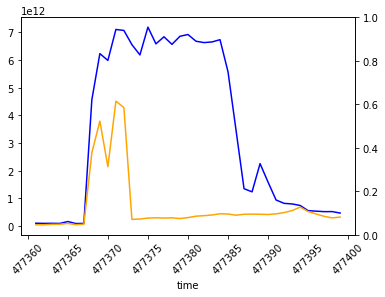

In [129]:
x = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['block_number']
y1 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['y']
y2 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['y_pred']
y3 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['pct_diff']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
ax1.plot(x, y2, color='orange')
#ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

In [130]:
lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]

,dt,block_number,y,y_pred,diff,pct_diff,abs_pct_diff
477361,2021-10-18 02:06:27,477361,1.038663e+11,4.661805e+10,-5.724823e+10,-0.551172,0.551172
477362,2021-10-18 02:06:50,477362,9.774531e+10,4.735625e+10,-5.038906e+10,-0.515514,0.515514
477363,2021-10-18 02:07:01,477363,1.002830e+11,6.279129e+10,-3.749171e+10,-0.373859,0.373859
477364,2021-10-18 02:07:12,477364,9.589795e+10,6.587830e+10,-3.001965e+10,-0.313037,0.313037
477365,2021-10-18 02:07:21,477365,1.649552e+11,9.560752e+10,-6.934764e+10,-0.420403,0.420403
477366,2021-10-18 02:07:41,477366,9.245374e+10,5.151700e+10,-4.093674e+10,-0.442781,0.442781
477367,2021-10-18 02:07:43,477367,9.725810e+10,6.658294e+10,-3.067516e+10,-0.315400,0.315400
477368,2021-10-18 02:07:50,477368,4.564990e+12,2.651180e+12,-1.913810e+12,-0.419236,0.419236
477369,2021-10-18 02:08:56,477369,6.227225e+12,3.789481e+12,-2.437745e+12,-0.391466,0.391466
477370,2021-10-18 02:09:19,477370,5.981332e+12,2.144106e+12,-3.837227e+12,-0.641534,0.641534


In [132]:
X_dev.loc[477360:477400][lin_reg_features]

,size_pct_chg_last_100_to_5,size_pct_chg_last_5,base_fee_per_gas_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,gas_price_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,number_transactions_in_block_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5
477360,-0.260413,-0.538728,-0.352447,0.023567,-0.473419,0.024415,0.045767,-0.564551,-0.473419,0.024415
477361,-0.090185,-0.269690,-0.352445,-0.088109,-0.488014,-0.104420,1.226415,-0.313559,-0.488014,-0.104420
477362,-0.927151,5.218382,-0.352409,-0.085721,-0.450250,-0.106373,-0.932927,5.363636,-0.450250,-0.106373
477363,35.948339,-0.111538,-0.450572,0.032806,-0.649575,0.107697,-0.728546,0.058065,-0.649575,0.107697
477364,-0.856972,3.844087,-0.369302,0.034532,-0.356001,0.055467,-0.825871,1.828571,-0.356001,0.055467
477365,-0.691936,-0.925398,-0.398777,0.157317,-0.538434,0.482609,27.428571,-0.924623,-0.538434,0.482609
477366,2.290452,0.051718,-0.400959,0.017960,-0.821716,-0.109877,0.944000,0.337449,-0.821716,-0.109877
477367,3.262362,-0.405923,-0.275081,0.018088,-0.390881,-0.004984,-0.009434,-0.557143,-0.390881,-0.004984
477368,-0.071171,-0.831126,-0.186182,-0.051663,-0.389395,44.521078,0.413793,-0.676829,-0.389395,44.521078
477369,2.386336,-0.742901,-0.155279,0.056859,-0.284530,63.935959,1.414634,-0.424242,-0.284530,63.935959


In [135]:
data.loc[477393]['size']

75053

In [137]:
data.loc[477292]['size']

31549

In [140]:
X_dev.columns

Index(['lag_cutoff_60', 'latest_avail_60', 'datetime', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_

## Ridge Regression

In [31]:
# Prep the results dataframe

# Collapse the list of features into one field
temp_list = []
for i in range(len(lin_reg_features_list)):
    temp_list.append(','.join(lin_reg_features_list[i]))
ridge_regression_results_df = pd.DataFrame(temp_list,
                                            columns=['Features'])

# Create empty columns for the results
ridge_regression_results_df['Coefficients'] = ''
ridge_regression_results_df['Rsq_Train'] = ''
ridge_regression_results_df['Rsq_Dev'] = ''
ridge_regression_results_df['RMSE_Train'] = ''
ridge_regression_results_df['RMSE_Dev'] = ''
ridge_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"size_pct_chg_last_25_to_5,size_pct_chg_last_5,...",,,,,
1,"size_pct_chg_last_50_to_5,size_pct_chg_last_5,...",,,,,
2,"size_pct_chg_last_100_to_5,size_pct_chg_last_5...",,,,,


In [32]:
rr_coeff_list = []
rr_rmse_train_list = []
rr_rmse_dev_list = []
rr_rsq_train_list = []
rr_rsq_dev_list = []

for l in lin_reg_features_list:
    ridge_reg = Ridge(alpha=0.75, random_state=42)

    lin_reg_features = l

    # fit train and test data. 
    ridge_reg.fit(X_train[lin_reg_features], Y_train)

    # Predict train data. 
    y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

    # Get training metrics
    rr_mse_train = mean_squared_error(Y_train, y_train_pred)
    rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

    # Predict dev data. 
    y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

    rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
    rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
    rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)
    
    # Store all of the results in lists
    rr_coeff_list.append(ridge_reg.coef_)
    rr_rmse_train_list.append(rr_rmse_train)
    rr_rmse_dev_list.append(rr_rmse_dev)
    rr_rsq_train_list.append(rr_r2score_train)
    rr_rsq_dev_list.append(rr_r2score_dev)

# Store the lists of results into the results dataframe
ridge_regression_results_df['Coefficients'] = rr_coeff_list
ridge_regression_results_df['RMSE_Train'] = rr_rmse_train_list
ridge_regression_results_df['RMSE_Dev'] = rr_rmse_dev_list
ridge_regression_results_df['Rsq_Train'] = rr_rsq_train_list
ridge_regression_results_df['Rsq_Dev'] = rr_rsq_dev_list

ridge_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"size_pct_chg_last_25_to_5,size_pct_chg_last_5,...","[[-2384978.91947304, -13138509.246435782, 1446...",0.864984,0.230343,9.920942e+10,1.217218e+11
1,"size_pct_chg_last_50_to_5,size_pct_chg_last_5,...","[[-6301262.128048003, -3847609.6811869177, 721...",0.864984,0.261015,9.920942e+10,1.192718e+11
2,"size_pct_chg_last_100_to_5,size_pct_chg_last_5...","[[-2787582.408074874, 1370540.2431817343, 6232...",0.864984,0.296590,9.920942e+10,1.163654e+11


In [33]:
ridge_regression_results_df.to_csv(r'data/ridge_regression_results.csv')

In [34]:

lin_reg_features = ['size_pct_chg_last_100_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5']

#Instantiate regression
ridge_reg = Ridge(alpha=0.75, random_state=42)

# fit train and test data. 
ridge_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

# Get training metrics
rr_mse_train = mean_squared_error(Y_train, y_train_pred)
rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Ridge Regression model on train data is: %.4f'%rr_mse_train)
print ('The RMSE of the Ridge Regression model on train data is: %.4f'%rr_rmse_train)
print ('The R^2 of the Ridge Regression model on train data is: %.4f'%rr_r2score_train)

# Predict dev data. 
y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)

print ('The MSE of the Ridge Regression model on dev data is: %.4f'%rr_mse_dev)
print ('The RMSE of the Ridge Regression model on dev data is: %.4f'%rr_rmse_dev)
print ('The R^2 of the Ridge Regression model on dev data is: %.4f'%rr_r2score_dev)

print("coefficients:", ridge_reg.coef_)

The MSE of the Ridge Regression model on train data is: 9842508421512034254848.0000
The RMSE of the Ridge Regression model on train data is: 99209417000.1620
The R^2 of the Ridge Regression model on train data is: 0.8650
The MSE of the Ridge Regression model on dev data is: 13540917323002116308992.0000
The RMSE of the Ridge Regression model on dev data is: 116365447290.0015
The R^2 of the Ridge Regression model on dev data is: 0.2966
coefficients: [[-2.78758241e+06  1.37054024e+06  6.23273260e+10  8.49025061e+10
   1.33977401e+09  2.90567788e+10 -1.13331258e+08  7.65217746e+07
   1.33977403e+09  2.90567786e+10]]


## Random Forest

#### Hyperparameter Tuning Random Search

In [35]:
n_estimators = [100, 200, 500, 1000]
max_depth = [2, 3, 5, 7, 10]
max_features = [3, 4, 5, 7, 10]
min_samples_leaf = [5, 10, 25, 50, 100, 200, 500]

rf_hyperparameters = []
for i in range(10):
    ne = random.randint(0, len(n_estimators)-1)
    md = random.randint(0, len(max_depth)-1)
    mf = random.randint(0, len(max_features)-1)
    msl = random.randint(0, len(min_samples_leaf)-1)
    rf_hyperparameters.append([n_estimators[ne],
                               max_depth[md],
                               max_features[mf],
                               min_samples_leaf[msl]])
rf_hyperparameters_df = pd.DataFrame(rf_hyperparameters,
                                  columns=['n_estimators',
                                           'max_depth',
                                           'max_features',
                                           'min_samples_leaf'])
print(rf_hyperparameters_df)


   n_estimators  max_depth  max_features  min_samples_leaf
0          1000          5             5               500
1           200         10             7               200
2           500         10             7                25
3           100          7             5                10
4           100          2             7                25
5           500          7            10               500
6          1000          7             4                50
7          1000          3             5               200
8           100          5             4               500
9           100          3             3               200


#### Run the random forest models

In [ ]:
print(datetime.datetime.now())

In [ ]:
# Set the random forest features
rf_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']


# Set the index of the list of hyperparameters
ne_idx = 0
md_idx = 1
mf_idx = 2
msl_idx = 3

# Initialize rmse lists of models
rf_RMSE_train_list = []
rf_RMSE_dev_list = []

counter = 1

# Loop through hyperparameters and run random forest models
for h in range(len(rf_hyperparameters)):
    
    # Instantiate the random forest
    rf = RandomForestRegressor(n_estimators = rf_hyperparameters[h][ne_idx], 
                               max_depth = rf_hyperparameters[h][ne_idx],
                               bootstrap = True,
                               max_features = rf_hyperparameters[h][mf_idx],
                               min_samples_leaf = rf_hyperparameters[h][msl_idx],
                               random_state = 42)

    # Train the model on the training data
    rf.fit(X_train[rf_features], Y_train)

    # Get the predictions on the training data set
    rf_train_predictions = rf.predict(X_train[rf_features])

    # Get the predictions on the dev data set
    rf_dev_predictions = rf.predict(X_dev[rf_features])


    rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
    rf_RMSE_train = np.sqrt(rf_MSE_train)
    rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
    rf_RMSE_dev = np.sqrt(rf_MSE_dev)
    rf_RMSE_train_list.append(rf_RMSE_train)
    rf_RMSE_dev_list.append(rf_RMSE_dev)
    
    # Purely to show progress
    print("Model #", counter)
    counter += 1

# Append the RMSE's to the dataframe
rf_hyperparameters_df['RMSE_Train'] = rf_RMSE_train_list
rf_hyperparameters_df['RMSE_Dev'] = rf_RMSE_dev_list

In [ ]:
print(datetime.datetime.now())

In [ ]:
rf_hyperparameters_df.sort_values(by='RMSE_Dev')

In [ ]:
rf_hyperparameters_df.to_csv(r'data/rf_hyperparameters.csv')

#### Run the Final Random Forest Model After Picking Hyperparameters

In [49]:
rf_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']


In [50]:
# Instantiate the random forest
rf = RandomForestRegressor(n_estimators = 1000, 
                           max_depth = 10,
                           bootstrap = True,
                           max_features = 7,
                           min_samples_leaf = 25,
                           random_state = 42)

# Train the model on the training data
rf.fit(X_train[rf_features], Y_train)

# Get the predictions on the training data set
rf_train_predictions = rf.predict(X_train[rf_features])

# Get the predictions on the dev data set
rf_dev_predictions = rf.predict(X_dev[rf_features])


rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
rf_RMSE_train = np.sqrt(rf_MSE_train)
rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
rf_RMSE_dev = np.sqrt(rf_MSE_dev)
print("rf_RMSE_train:", rf_RMSE_train)
print("rf_RMSE_dev:", rf_RMSE_dev)

rf_RMSE_train: 243402140016.38568
rf_RMSE_dev: 82947248055.7531


#### Feature Importance

                                            Features  Feature_Importance
8      effective_gas_price_mean_pct_chg_last_50_to_5            0.227624
4                gas_price_mean_pct_chg_last_50_to_5            0.219761
9            effective_gas_price_mean_pct_chg_last_5            0.218064
5                      gas_price_mean_pct_chg_last_5            0.215935
2              base_fee_per_gas_pct_chg_last_50_to_5            0.102294
3                    base_fee_per_gas_pct_chg_last_5            0.010459
0                          size_pct_chg_last_50_to_5            0.002003
6  number_transactions_in_block_pct_chg_last_50_to_5            0.001389
1                                size_pct_chg_last_5            0.001253
7        number_transactions_in_block_pct_chg_last_5            0.001218


<AxesSubplot:title={'center':'Random Forest Feature Importance'}, ylabel='Features'>

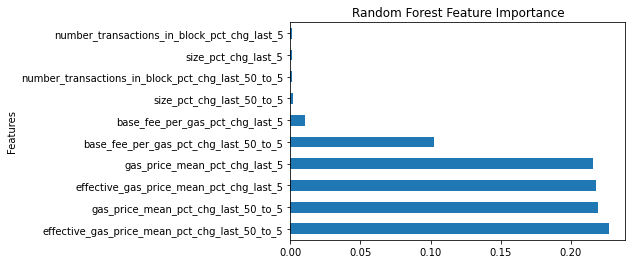

In [51]:
rf_feature_importances = rf.feature_importances_
rf_feature_importances_dict = {'Features': rf_features,
                               'Feature_Importance': rf_feature_importances}
rf_feature_importances_df = pd.DataFrame(rf_feature_importances_dict)
rf_feature_importances_df.sort_values(by=['Feature_Importance'], 
                                      ascending=False,
                                      inplace=True)
print(rf_feature_importances_df.head(30))

rf_feature_importances_df = rf_feature_importances_df.set_index('Features')
rf_feature_importances_df['Feature_Importance'].nlargest(15).plot(kind='barh',
                                                                  title='Random Forest Feature Importance')

In [ ]:
data.columns

## Gradient Boosting

#### Hyperparameter Tuning Random Search

In [54]:
# Gradient boosing hyperparameter random search
booster = ['dart', 'gbtree', 'gblinear']
max_depth = [2, 3, 5, 6, 7, 10]
learning_rate = [.001, .005, .01, .05]
subsample = [0.5, 0.6, 0.7]
rate_drop = [0.00, 0.10, 0.20, 0.40]
min_child_weight = [1, 5, 10, 25, 50, 100, 200, 500]
training_rounds = [200, 500, 1000]

xgb_hyperparameters = []
for i in range(10):
    
    # Randomly pick from specific hyperparameter lists
    b = random.randint(0, len(booster)-1)
    md = random.randint(0, len(max_depth)-1)
    l = random.randint(0, len(learning_rate)-1)
    s = random.randint(0, len(subsample)-1)
    r = random.randint(0, len(rate_drop)-1)
    mcw = random.randint(0, len(min_child_weight)-1)
    t = random.randint(0, len(training_rounds)-1)
    
    xgb_hyperparameters.append([booster[b],
                                max_depth[md],
                                learning_rate[l],
                                subsample[s],
                                rate_drop[r],
                                min_child_weight[mcw],
                                training_rounds[t]])

# Store randomly chosen hyperparameters into dataframe
xgb_hyperparameters_df = pd.DataFrame(xgb_hyperparameters,
                                      columns=['booster',
                                               'max_depth',
                                               'learning_rate',
                                               'subsample',
                                               'rate_drop',
                                               'min_child_weight',
                                               'training_rounds'])

In [55]:
xgb_hyperparameters_df

,booster,max_depth,learning_rate,subsample,rate_drop,min_child_weight,training_rounds
0,gblinear,7,0.050,0.7,0.0,5,200
1,dart,10,0.001,0.7,0.1,500,1000
2,dart,10,0.050,0.7,0.1,500,200
3,gblinear,6,0.001,0.6,0.0,10,500
4,gbtree,6,0.050,0.5,0.2,10,200
5,gbtree,10,0.010,0.5,0.0,500,500
6,gbtree,2,0.010,0.5,0.0,200,200
7,gblinear,3,0.010,0.6,0.1,100,1000
8,gblinear,6,0.050,0.7,0.4,50,1000
9,gbtree,7,0.005,0.7,0.1,500,200


#### Run the gradient boosting models

In [ ]:
# Set the gradient boosting features
xgb_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

# Set the index of the list of hyperparameters
b_idx = 0
md_idx = 1
l_idx = 2
s_idx = 3
r_idx = 4
mcw_idx = 5
t_idx = 6

# Initialize rmse lists of models
xgb_RMSE_train_list = []
xgb_RMSE_dev_list = []

# Loop through hyperparameters and run random forest models
for h in range(len(xgb_hyperparameters)):
    
    #set up the training matrix
    dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
    xgb_dict = {
            'booster': xgb_hyperparameters[h][b_idx],
            'max_depth': xgb_hyperparameters[h][md_idx],
            'random_state': 42,
            'learning_rate': xgb_hyperparameters[h][l_idx],
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'sample_type': 'uniform',
            'subsample': xgb_hyperparameters[h][s_idx],
            'normalize_type': 'tree',
            'rate_drop': xgb_hyperparameters[h][r_idx],
            'min_child_weight': xgb_hyperparameters[h][mcw_idx]
        }
    #starting hyperparameter of training rounds
    training_rounds = xgb_hyperparameters[h][t_idx]

    #train the model
    bst = xgb.train(
        xgb_dict,
        dtrain,
        training_rounds,
        evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
        early_stopping_rounds=10) 


    training_rounds = bst.best_ntree_limit

    #get training predictions and MSE
    xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
    xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
    xgb_train_rmse = np.sqrt(xgb_train_mse)

    #get dev predictions and MSE
    xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
    xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
    xgb_dev_rmse = np.sqrt(xgb_dev_mse)

    xgb_RMSE_train_list.append(xgb_train_rmse)
    xgb_RMSE_dev_list.append(xgb_dev_rmse)


# Append the RMSE's to the dataframe
xgb_hyperparameters_df['RMSE_Train'] = xgb_RMSE_train_list
xgb_hyperparameters_df['RMSE_Dev'] = xgb_RMSE_dev_list

In [ ]:
xgb_hyperparameters_df.sort_values(by='RMSE_Dev')

In [ ]:
xgb_hyperparameters_df.to_csv(r'data/xgb_hyperparameters.csv')

#### Run the Final Gradient Boosting Model After Picking Hyperparameters

In [52]:
xgb_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

In [56]:
#set up the training matrix
dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
xgb_dict = {
        'booster': 'gbtree',
        'max_depth': 7,
        'random_state': 42,
        'learning_rate': .01,
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'sample_type': 'uniform',
        'subsample': 0.7,
        'normalize_type': 'tree',
        'rate_drop': 0.4,
        'min_child_weight': 1
    }
#starting hyperparameter of training rounds
training_rounds = 200

#train the model
bst = xgb.train(
    xgb_dict,
    dtrain,
    training_rounds,
    evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
    early_stopping_rounds=10) 


training_rounds = bst.best_ntree_limit

#get training predictions and MSE
xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)

#print("XGB train mean squared error:", xgb_train_mse)
print("XGB train root mean squared error:", xgb_train_rmse)

#get dev predictions and MSE
xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
xgb_dev_rmse = np.sqrt(xgb_dev_mse)

#print("XGB dev mean squared error:", xgb_dev_mse)
print("XGB dev root mean squared error:", xgb_dev_rmse)

[0]	RMSE-rmse:183492329472.00000
[1]	RMSE-rmse:182463594496.00000
[2]	RMSE-rmse:181343813632.00000
[3]	RMSE-rmse:180345618432.00000
[4]	RMSE-rmse:179302891520.00000
[5]	RMSE-rmse:178309709824.00000
[6]	RMSE-rmse:177234182144.00000
[7]	RMSE-rmse:176216293376.00000
[8]	RMSE-rmse:175240134656.00000
[9]	RMSE-rmse:174266761216.00000
[10]	RMSE-rmse:173311016960.00000
[11]	RMSE-rmse:172332810240.00000
[12]	RMSE-rmse:171350933504.00000
[13]	RMSE-rmse:170358833152.00000
[14]	RMSE-rmse:169315237888.00000
[15]	RMSE-rmse:168396947456.00000
[16]	RMSE-rmse:167504412672.00000
[17]	RMSE-rmse:166558482432.00000
[18]	RMSE-rmse:165527552000.00000
[19]	RMSE-rmse:164672176128.00000
[20]	RMSE-rmse:163840344064.00000
[21]	RMSE-rmse:163015671808.00000
[22]	RMSE-rmse:162110881792.00000
[23]	RMSE-rmse:161107476480.00000
[24]	RMSE-rmse:160333348864.00000
[25]	RMSE-rmse:159486902272.00000
[26]	RMSE-rmse:158692720640.00000
[27]	RMSE-rmse:157914447872.00000
[28]	RMSE-rmse:157034758144.00000
[29]	RMSE-rmse:156213116

In [ ]:
#feature importance
xgb_importance_weight = bst.get_score(importance_type='weight')
xgb_importance_gain = bst.get_score(importance_type='gain')
xgb_importance_weight_df = pd.DataFrame.from_dict(xgb_importance_weight,
                                                  orient='index',
                                                  columns=['weight'])
xgb_importance_gain_df = pd.DataFrame.from_dict(xgb_importance_gain,
                                                  orient='index',
                                                  columns=['gain'])
xgb_feature_importance_df = xgb_importance_weight_df.join(xgb_importance_gain_df)
xgb_feature_importance_df.sort_values(by=['weight'], ascending=False, inplace=True)                 
print(xgb_feature_importance_df.head(30))


In [ ]:
plot_importance(bst, max_num_features=30)

## Loading From File

In [44]:
lr_results_from_file = pd.read_csv(r'data/linear_regression_results.csv')
lr_results_from_file['Model'] = 'Linear Regression'
lr_results_from_file = lr_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in lr_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

rr_results_from_file = pd.read_csv(r'data/ridge_regression_results.csv')
rr_results_from_file['Model'] = 'Ridge Regression'
rr_results_from_file = rr_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in rr_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

rf_results_from_file = pd.read_csv(r'data/rf_hyperparameters.csv')
rf_results_from_file['Model'] = 'Random Forest'
rf_results_from_file = rf_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in rf_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

xgb_results_from_file = pd.read_csv(r'data/xgb_hyperparameters.csv')
xgb_results_from_file['Model'] = 'Gradient Boosting'
xgb_results_from_file = xgb_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in xgb_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]


In [45]:
results_all_df = lr_results_from_file.append(rr_results_from_file).append(rf_results_from_file).append(xgb_results_from_file)

In [47]:
results_all_df = results_all_df.sort_values(by=['RMSE_Dev', 'RMSE_Train'])
results_all_df

,Model,RMSE_Dev,RMSE_Train,Unnamed: 0,Features,Coefficients,Rsq_Train,Rsq_Dev,n_estimators,max_depth,max_features,min_samples_leaf,booster,learning_rate,subsample,rate_drop,min_child_weight,training_rounds
2,Random Forest,8.201272e+10,2.423501e+11,2,NaN,NaN,NaN,NaN,1000.0,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
5,Random Forest,8.251172e+10,2.423941e+11,5,NaN,NaN,NaN,NaN,500.0,2.0,5.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
6,Random Forest,8.606034e+10,2.462958e+11,6,NaN,NaN,NaN,NaN,100.0,10.0,10.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Random Forest,8.705298e+10,2.462476e+11,9,NaN,NaN,NaN,NaN,1000.0,10.0,5.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Random Forest,8.706493e+10,2.462468e+11,4,NaN,NaN,NaN,NaN,200.0,7.0,5.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Random Forest,8.902324e+10,2.464465e+11,3,NaN,NaN,NaN,NaN,500.0,5.0,3.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
0,Random Forest,9.560334e+10,2.493508e+11,0,NaN,NaN,NaN,NaN,1000.0,2.0,4.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
6,Gradient Boosting,9.563024e+10,1.315841e+11,6,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,gbtree,0.010,0.7,0.4,1.0,200.0
1,Random Forest,1.026660e+11,2.522471e+11,1,NaN,NaN,NaN,NaN,1000.0,3.0,10.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Gradient Boosting,1.030321e+11,2.515721e+11,8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,dart,0.050,0.5,0.0,200.0,200.0


## Ensemble

In [57]:
ensemble_train_preds = (y_train_pred.ravel() + y_train_pred_rr.ravel() + rf_train_predictions + xgb_train_pred) / 4
print("train_rmse =", np.sqrt(mean_squared_error(ensemble_train_preds, Y_train)))


train_rmse = 116178775490.90768


In [59]:
ensemble_dev_preds = (y_dev_pred_lr.ravel() + y_dev_pred_rr.ravel() + rf_dev_predictions + xgb_dev_pred) / 4
print("dev_rmse =", np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev)))

dev_rmse = 97696145767.18451
